<a href="https://colab.research.google.com/github/Santosdevbjj/analiseRiscosAtrasoObras/blob/main/Notebooks/02_modelagem_preditiva.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# ============================================================
# 1. Preparação do Ambiente e Clonagem (CCbjj Edition)
# ============================================================
import os

# Define o nome do repositório
repo_name = 'analiseRiscosAtrasoObras'

# Lógica de clonagem/atualização mais segura
if not os.path.exists(repo_name):
    print(f"📥 Clonando o repositório {repo_name}...")
    !git clone https://github.com/Santosdevbjj/{repo_name}.git
    %cd {repo_name}
else:
    # Se já estiver dentro da pasta, não tenta dar CD novamente para evitar erro
    if os.path.basename(os.getcwd()) != repo_name:
        %cd {repo_name}
    print("✅ Repositório já presente. Atualizando...")
    !git pull origin main

# Instalação de dependências
!pip install -q joblib pandas numpy scikit-learn matplotlib plotly faker

# Garantir estrutura de pastas para os próximos passos
os.makedirs('data/raw', exist_ok=True)
os.makedirs('models', exist_ok=True)

# ============================================================
# 2. Imports e Carregamento
# ============================================================
import pandas as pd
import numpy as np

try:
    path = "data/raw/"

    # Carregamento e PADRONIZAÇÃO IMEDIATA (Colunas em minúsculo)
    atividades   = pd.read_csv(f"{path}atividadesccbjj.csv")
    atividades.columns = [c.lower() for c in atividades.columns]

    fornecedores = pd.read_csv(f"{path}fornecedoresccbjj.csv")
    fornecedores.columns = [c.lower() for c in fornecedores.columns]

    obras        = pd.read_csv(f"{path}obrasccbjj.csv")
    obras.columns = [c.lower() for c in obras.columns]

    suprimentos  = pd.read_csv(f"{path}suprimentosccbjj.csv")
    suprimentos.columns = [c.lower() for c in suprimentos.columns]

    base_bot     = pd.read_csv(f"{path}base_consulta_botccbjj.csv")
    base_bot.columns = [c.lower() for c in base_bot.columns]

    print("🚀 Dados da CCbjj Engenharia carregados e padronizados!\n")

    # Validação de Features Críticas
    features_obrigatorias = ['nivel_chuva', 'tipo_solo']
    for feat in features_obrigatorias:
        if feat not in base_bot.columns:
            print(f"⚠️ AVISO: Coluna '{feat}' não encontrada. O modelo pode precisar de simulação.")
        else:
            print(f"✅ Variável '{feat}' detectada.")

except FileNotFoundError as e:
    print(f"❌ Erro: Arquivo não encontrado. Verifique os nomes no seu GitHub.")
    print(f"Detalhe: {e}")

# ============================================================
# 3. Visualização Diagnóstica
# ============================================================
datasets = {
    "Atividades": atividades,
    "Fornecedores": fornecedores,
    "Obras": obras,
    "Suprimentos": suprimentos,
    "Base Consolidada IA": base_bot
}

for nome, df in datasets.items():
    print(f"📌 {nome} | Shape: {df.shape}")
    display(df.head(2))

/content/analiseRiscosAtrasoObras
✅ Repositório já presente. Atualizando...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Unpacking objects: 100% (4/4), 347.00 KiB | 1.19 MiB/s, done.
From https://github.com/Santosdevbjj/analiseRiscosAtrasoObras
 * branch            main       -> FETCH_HEAD
   7c370d4..c9a8410  main       -> origin/main
Updating 7c370d4..c9a8410
Fast-forward
 Notebooks/02_modelagem_preditiva.ipynb | 392 ++++++++++++++++++++++-----------
 1 file changed, 259 insertions(+), 133 deletions(-)
🚀 Dados da CCbjj Engenharia carregados e padronizados!

✅ Variável 'nivel_chuva' detectada.
✅ Variável 'tipo_solo' detectada.
📌 Atividades | Shape: (600, 6)


,id_atividade,id_obra,id_fornecedor,etapa,dias_atraso,status
0,CCBJJ-100_fundação,CCBJJ-100,FORN-20,fundação,12.6,atrasado
1,CCBJJ-100_estrutura,CCBJJ-100,FORN-23,estrutura,9.7,atrasado


📌 Fornecedores | Shape: (40, 3)


,id_fornecedor,nome_fornecedor,rating_confiabilidade
0,FORN-1,Araújo,3.6
1,FORN-2,Ramos da Mota - EI,1.1


📌 Obras | Shape: (200, 7)


,id_obra,nome_empreendimento,cidade,tipo_solo,orcamento_estimado,complexidade_obra,data_inicio_prevista
0,CCBJJ-100,Residencial Recanto De Nogueira,recife,argiloso,22614295.91,16.934093,2025-04-23
1,CCBJJ-101,Residencial Praia De Fernandes,são paulo,argiloso,24326708.52,17.007085,2025-03-04


📌 Suprimentos | Shape: (300475, 5)


,id_obra,id_atividade,id_fornecedor,material,atrasou_entrega
0,CCbjj-100,CCbjj-100_Fundação,FORN-361,Madeira,0
1,CCbjj-100,CCbjj-100_Fundação,FORN-735,Brita,0


📌 Base Consolidada IA | Shape: (600, 11)


,id_obra,orcamento_estimado,rating_confiabilidade,taxa_insucesso_fornecedor,complexidade_obra,risco_etapa,nivel_chuva,tipo_solo,material,cidade,etapa
0,CCBJJ-100,22614295.91,1.0,0.09,16.934093,12.6,47,argiloso,areia,recife,fundação
1,CCBJJ-100,22614295.91,2.4,0.32,16.934093,9.7,47,argiloso,madeira,recife,estrutura


In [2]:

# ============================================================
# 2. Configuração do Ambiente de IA (Pipeline & Estética)
# ============================================================
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import os  # Adicionado para gestão de diretórios
import warnings # Adicionado para limpeza de log

# Desativar avisos chatos de depreciação
warnings.filterwarnings('ignore')

# Ferramentas de Engenharia de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Configurações de exibição e estética CCbjj
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.titlesize'] = 16

# Cores da Identidade Visual CCbjj (Verde Profissional e Destaques)
paleta_ccbjj = ["#004A2F", "#00A859", "#2E86C1", "#E67E22"]
sns.set_palette(sns.color_palette(paleta_ccbjj))

# Garantir que as pastas de exportação existam desde o início
os.makedirs('data/raw', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("✅ Setup de IA concluído. Infraestrutura de diretórios e estética carregadas.")

✅ Setup de IA concluído. Infraestrutura de diretórios e estética carregadas.


In [3]:

# ============================================================
# 3. Validação e Inspeção de Dados (Ecossistema CCbjj)
# ============================================================

# Nota: Os dados já foram carregados na Célula 1.
# Aqui apenas garantimos que a base_ia (usada no treinamento) está correta.

# Sincronizando nomes (Caso você tenha usado base_bot na Célula 1)
if 'base_bot' in locals() and 'base_ia' not in locals():
    base_ia = base_bot

# Garantir que a padronização de minúsculas persista
for df_temp in [atividades, fornecedores, obras, suprimentos, base_ia]:
    df_temp.columns = [c.lower() for c in df_temp.columns]

# Exibição do sumário de carga (Métricas de Data Engineering)
print("🏗️ Status dos Datasets CCbjj:")
print(f"📊 Atividades:    {atividades.shape[0]} registros")
print(f"🏢 Obras:         {obras.shape[0]} registros")
print(f"🚚 Suprimentos:   {suprimentos.shape[0]} registros")
print(f"🤝 Fornecedores:  {fornecedores.shape[0]} registros")
print(f"🧠 Base de IA:    {base_ia.shape[0]} amostras para treinamento")

# ------------------------------------------------------------
# Verificação de colunas estratégicas para o Modelo de IA
# ------------------------------------------------------------
colunas_alvo = ['id_obra', 'nivel_chuva', 'tipo_solo', 'risco_etapa']
missing_cols = [c for c in colunas_alvo if c not in base_ia.columns]

if not missing_cols:
    print("\n🔍 Verificação de colunas preditivas OK:")
    display(base_ia[colunas_alvo].head())
else:
    print(f"\n⚠️ Atenção: Colunas ausentes na base_ia: {missing_cols}")
    print("Sugestão: Verifique o merge na Célula 4 ou a geração dos dados.")

🏗️ Status dos Datasets CCbjj:
📊 Atividades:    600 registros
🏢 Obras:         200 registros
🚚 Suprimentos:   300475 registros
🤝 Fornecedores:  40 registros
🧠 Base de IA:    600 amostras para treinamento

🔍 Verificação de colunas preditivas OK:


,id_obra,nivel_chuva,tipo_solo,risco_etapa
0,CCBJJ-100,47,argiloso,12.6
1,CCBJJ-100,47,argiloso,9.7
2,CCBJJ-100,47,argiloso,6.6
3,CCBJJ-101,307,argiloso,6.4
4,CCBJJ-101,307,argiloso,5.6


In [4]:

# ============================================================
# 4. Integração dos Dados (Consolidação Mestre CCbjj)
# ============================================================

# Padronização preventiva: Crucial para evitar KeyErrors
for df_tmp in [atividades, obras, suprimentos, fornecedores, base_ia]:
    df_tmp.columns = [c.lower() for c in df_tmp.columns]

# 1. Unir Atividades com Obras
df_mestre = atividades.merge(obras, on="id_obra", how="left", suffixes=('', '_obra'))

# 2. Adicionar Suprimentos (Cruzamento por atividade para identificar materiais)
df_mestre = df_mestre.merge(suprimentos, on=["id_obra", "id_atividade"], how="left", suffixes=('', '_sup'))

# 3. Adicionar Fornecedores
df_mestre = df_mestre.merge(fornecedores, on="id_fornecedor", how="left", suffixes=('', '_forn'))

# 4. Integração Inteligente com Base IA (Solo e Clima)
# Removemos colunas de clima/solo do mestre se já existirem para evitar conflito (_x, _y)
cols_to_drop = [c for c in ['nivel_chuva', 'tipo_solo'] if c in df_mestre.columns]
if cols_to_drop:
    df_mestre = df_mestre.drop(columns=cols_to_drop)

# Merge garantindo que não haja duplicatas na chave id_obra
df_mestre = df_mestre.merge(
    base_ia[['id_obra', 'nivel_chuva', 'tipo_solo']].drop_duplicates('id_obra'),
    on='id_obra',
    how='left'
)

# ------------------------------------------------------------
# Limpeza Seletiva de Colunas e Feature Engineering
# ------------------------------------------------------------
if 'orcamento_estimado' in df_mestre.columns:
    df_mestre['complexidade_obra'] = np.log1p(df_mestre['orcamento_estimado'].fillna(0))

# ------------------------------------------------------------
# Fallback para Clima e Solo (Garante que o modelo nunca receba NaN)
# ------------------------------------------------------------
# Nível de Chuva
if 'nivel_chuva' not in df_mestre.columns or df_mestre['nivel_chuva'].isnull().all():
    print("ℹ️ Simulando 'nivel_chuva' (dados ausentes)...")
    df_mestre['nivel_chuva'] = np.random.randint(30, 550, size=len(df_mestre))
else:
    median_chuva = df_mestre['nivel_chuva'].median()
    df_mestre['nivel_chuva'] = df_mestre['nivel_chuva'].fillna(median_chuva if not np.isnan(median_chuva) else 150)

# Tipo de Solo
if 'tipo_solo' not in df_mestre.columns or df_mestre['tipo_solo'].isnull().all():
    print("ℹ️ Simulando 'tipo_solo' (dados ausentes)...")
    df_mestre['tipo_solo'] = np.random.choice(['Arenoso', 'Argiloso', 'Rochoso', 'Siltoso'], size=len(df_mestre))
else:
    df_mestre['tipo_solo'] = df_mestre['tipo_solo'].fillna('Desconhecido')

# ------------------------------------------------------------
# Validação Final da Tabela de Treinamento
# ------------------------------------------------------------
colunas_preditivas = ['nivel_chuva', 'tipo_solo', 'orcamento_estimado', 'rating_confiabilidade', 'material']
missing = [c for c in colunas_preditivas if c not in df_mestre.columns]

if not missing:
    print("✅ Integração CCbjj concluída: Pronto para o Feature Engineering.")
else:
    print(f"⚠️ Atenção: Faltam colunas essenciais: {missing}")

print(f"📏 Shape da Tabela Mestre: {df_mestre.shape}")
display(df_mestre.head())

✅ Integração CCbjj concluída: Pronto para o Feature Engineering.
📏 Shape da Tabela Mestre: (600, 18)


,id_atividade,id_obra,id_fornecedor,etapa,dias_atraso,status,nome_empreendimento,cidade,orcamento_estimado,complexidade_obra,data_inicio_prevista,id_fornecedor_sup,material,atrasou_entrega,nome_fornecedor,rating_confiabilidade,nivel_chuva,tipo_solo
0,CCBJJ-100_fundação,CCBJJ-100,FORN-20,fundação,12.6,atrasado,Residencial Recanto De Nogueira,recife,22614295.91,16.934093,2025-04-23,NaN,NaN,NaN,Melo,1.0,47,argiloso
1,CCBJJ-100_estrutura,CCBJJ-100,FORN-23,estrutura,9.7,atrasado,Residencial Recanto De Nogueira,recife,22614295.91,16.934093,2025-04-23,NaN,NaN,NaN,Jesus - EI,2.4,47,argiloso
2,CCBJJ-100_acabamento,CCBJJ-100,FORN-19,acabamento,6.6,atrasado,Residencial Recanto De Nogueira,recife,22614295.91,16.934093,2025-04-23,NaN,NaN,NaN,Lima Moura S/A,4.2,47,argiloso
3,CCBJJ-101_fundação,CCBJJ-101,FORN-25,fundação,6.4,atrasado,Residencial Praia De Fernandes,são paulo,24326708.52,17.007085,2025-03-04,NaN,NaN,NaN,Macedo,4.8,307,argiloso
4,CCBJJ-101_estrutura,CCBJJ-101,FORN-15,estrutura,5.6,atrasado,Residencial Praia De Fernandes,são paulo,24326708.52,17.007085,2025-03-04,NaN,NaN,NaN,Ribeiro Barros - EI,3.6,307,argiloso


✅ Saneamento CCbjj concluído. Linhas para treino: 600
🔍 Nulos restantes: 1200
⚠️ ALERTA: Ainda existem nulos nas colunas: ['id_fornecedor_sup', 'atrasou_entrega']


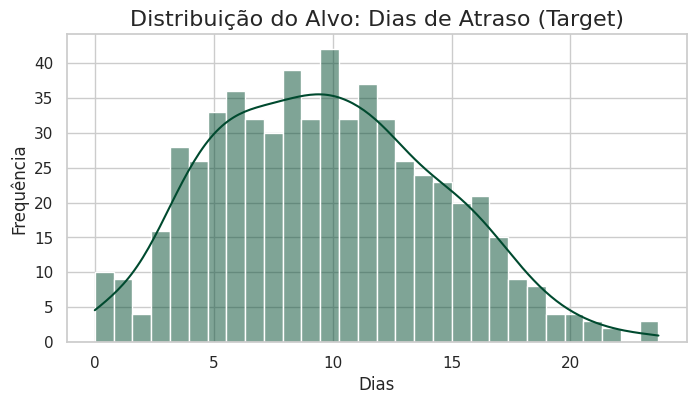

In [5]:

# ============================================================
# 5. Limpeza e Saneamento de Dados (Data Wrangling CCbjj)
# ============================================================
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Remover registros onde o alvo (target) é nulo ou negativo
df_mestre = df_mestre.dropna(subset=["dias_atraso"]).copy()
df_mestre = df_mestre[df_mestre["dias_atraso"] >= 0].copy()

# 2. Tratamento de Variáveis Numéricas (Foco em Estabilidade)
# Nota: Adicionamos variáveis que podem vir de merges anteriores
num_cols = ["rating_confiabilidade", "orcamento_estimado", "nivel_chuva", "taxa_insucesso_fornecedor"]

for col in num_cols:
    if col in df_mestre.columns:
        # Preenchimento com mediana (robusta contra outliers)
        mediana = df_mestre[col].median()
        df_mestre[col] = df_mestre[col].fillna(mediana if not np.isnan(mediana) else 0)

        # Clipping: Proteção contra ruídos extremos
        if col == "nivel_chuva":
            df_mestre[col] = df_mestre[col].clip(lower=0, upper=800)
        elif col == "rating_confiabilidade":
            df_mestre[col] = df_mestre[col].clip(lower=1, upper=5)
        elif col == "taxa_insucesso_fornecedor":
            df_mestre[col] = df_mestre[col].clip(lower=0, upper=1)

# 3. Tratamento de Variáveis Categóricas (Normalização CCbjj)
cols_categoricas = ["material", "cidade", "etapa", "tipo_solo"]

for col in cols_categoricas:
    if col in df_mestre.columns:
        # Preenchimento, remoção de espaços e padronização para minúsculo
        df_mestre[col] = df_mestre[col].fillna("n/a").astype(str).str.strip().str.lower()

# 4. Feature Engineering Extra: Complexidade_Obra
# Garantindo que a variável logarítmica esteja pronta para o modelo
if 'orcamento_estimado' in df_mestre.columns:
    df_mestre['complexidade_obra'] = np.log1p(df_mestre['orcamento_estimado'].fillna(0))

# 5. Verificação Final de Sanidade
nulos_restantes = df_mestre.isnull().sum().sum()
print(f"✅ Saneamento CCbjj concluído. Linhas para treino: {len(df_mestre)}")
print(f"🔍 Nulos restantes: {nulos_restantes}")

if nulos_restantes > 0:
    print("⚠️ ALERTA: Ainda existem nulos nas colunas:", df_mestre.columns[df_mestre.isnull().any()].tolist())

# Visualização da distribuição do alvo
plt.figure(figsize=(8, 4))
sns.histplot(df_mestre['dias_atraso'], bins=30, kde=True, color="#004A2F")
plt.title("Distribuição do Alvo: Dias de Atraso (Target)")
plt.xlabel("Dias")
plt.ylabel("Frequência")
plt.show()

In [6]:

# ============================================================
# 6. Feature Engineering (Engenharia de Variáveis CCbjj)
# ============================================================

# 1. Taxa de Insucesso do Fornecedor (Frequência Histórica de Atrasos)
if 'id_fornecedor' in df_mestre.columns and 'dias_atraso' in df_mestre.columns:
    df_mestre["taxa_insucesso_fornecedor"] = df_mestre.groupby("id_fornecedor")["dias_atraso"].transform(
        lambda x: (x > 0).mean()
    ).fillna(0.15) # Fallback para fornecedores novos
else:
    df_mestre["taxa_insucesso_fornecedor"] = 0.15

# 2. Complexidade da Obra (Logaritmo para normalizar grandes orçamentos)
if 'orcamento_estimado' in df_mestre.columns:
    # Usamos fillna(0) antes do log1p para evitar erro matemático
    df_mestre["complexidade_obra"] = np.log1p(df_mestre["orcamento_estimado"].fillna(0))

# 3. Risco Médio da Etapa (Target Encoding)
if 'etapa' in df_mestre.columns:
    df_mestre["risco_etapa"] = df_mestre.groupby("etapa")["dias_atraso"].transform("mean").fillna(0)

# 4. Score de Risco Solo-Clima (Interação Geotécnica)
# Mapeamento robusto: Solo Argiloso sob chuva é o pior cenário para fundações
pesos_solo = {'argiloso': 4.0, 'siltoso': 3.0, 'arenoso': 2.0, 'rochoso': 1.0, 'n/a': 2.0, 'desconhecido': 2.0}

if 'tipo_solo' in df_mestre.columns:
    # O .str.lower() já foi garantido na Célula 5, mas reforçamos aqui por segurança
    df_mestre['fator_clima_solo'] = df_mestre['nivel_chuva'] * df_mestre['tipo_solo'].str.lower().map(pesos_solo).fillna(2.0)
else:
    df_mestre['fator_clima_solo'] = df_mestre['nivel_chuva'] * 2.0

# 5. Feature Logística: Score de Confiabilidade do Suprimento
materiais_criticos = {'aço': 1.5, 'cimento': 1.3, 'brita': 1.1, 'madeira': 1.0, 'piso': 1.0}

if 'material' in df_mestre.columns:
    # Mapeia o peso do material e evita divisão por valores menores que 1
    peso_mat = df_mestre['material'].str.lower().map(materiais_criticos).fillna(1.0)
    rating_safe = df_mestre['rating_confiabilidade'].fillna(3.5)
    df_mestre['score_logistica'] = rating_safe / peso_mat

print("✅ Feature Engineering CCbjj concluída!")
print(f"📈 Total de colunas agora: {len(df_mestre.columns)}")

# Visualização das colunas calculadas
cols_analise = ["id_obra", "etapa", "tipo_solo", "nivel_chuva", "fator_clima_solo",
                "taxa_insucesso_fornecedor", "complexidade_obra", "score_logistica"]
cols_presentes = [c for c in cols_analise if c in df_mestre.columns]

display(df_mestre[cols_presentes].head())

✅ Feature Engineering CCbjj concluída!
📈 Total de colunas agora: 22


,id_obra,etapa,tipo_solo,nivel_chuva,fator_clima_solo,taxa_insucesso_fornecedor,complexidade_obra,score_logistica
0,CCBJJ-100,fundação,argiloso,47,188.0,1.000000,16.934093,1.0
1,CCBJJ-100,estrutura,argiloso,47,188.0,1.000000,16.934093,2.4
2,CCBJJ-100,acabamento,argiloso,47,188.0,1.000000,16.934093,4.2
3,CCBJJ-101,fundação,argiloso,307,1228.0,1.000000,17.007085,4.8
4,CCBJJ-101,estrutura,argiloso,307,1228.0,0.944444,17.007085,3.6


In [7]:

# ============================================================
# 7. Sincronização de Features (Arquitetura CCbjj IA 2.0)
# ============================================================

# 1. Lista Mestra de Features (Obrigatórias para o Pipeline do Modelo)
features_modelo = [
    "orcamento_estimado",
    "rating_confiabilidade",
    "taxa_insucesso_fornecedor",
    "complexidade_obra",
    "risco_etapa",
    "nivel_chuva",
    "tipo_solo",
    "material",
    "cidade",
    "etapa"
]

# 2. Blindagem: Garantir que TODAS as colunas do contrato existam no df_mestre
# Se algo sumiu nos processos anteriores, restauramos com valores neutros
for col in features_modelo:
    if col not in df_mestre.columns:
        if col in ['tipo_solo', 'material', 'cidade', 'etapa']:
            df_mestre[col] = "n/a"  # Alinhado com a limpeza da Célula 5
            print(f"⚠️ Aviso: Feature categórica '{col}' foi restaurada como 'n/a'.")
        else:
            # Para numéricos, tentamos usar a mediana global se a coluna existir mas estiver vazia
            df_mestre[col] = 0.0
            print(f"⚠️ Aviso: Feature numérica '{col}' foi restaurada como 0.0.")

# 3. Definição da Variável Alvo (Target)
# Removemos qualquer nulo residual no alvo para não "enganar" a IA
df_mestre = df_mestre.dropna(subset=["dias_atraso"])
y = df_mestre["dias_atraso"]

# 4. Seleção das Variáveis de Entrada (Features)
# Copiamos apenas o que o modelo foi desenhado para processar
X = df_mestre[features_modelo].copy()

# 5. Validação de Sanidade das Features
print("\n🏗️ Sincronização CCbjj concluída com sucesso!")
print(f"📊 Volume de Treino: {X.shape[0]} amostras")
print(f"🧩 Features Ativas:  {X.shape[1]} colunas preditivas")

# Verificação de tipos (OneHotEncoder exige strings para categóricos)
print("\n🔍 Verificação de Tipagem:")
# Forçamos as colunas categóricas a serem string por segurança extrema
cols_cat = ['tipo_solo', 'material', 'cidade', 'etapa']
for c in cols_cat:
    X[c] = X[c].astype(str)

print(X.dtypes)

# Preview final antes do Treinamento
display(X.head())


🏗️ Sincronização CCbjj concluída com sucesso!
📊 Volume de Treino: 600 amostras
🧩 Features Ativas:  10 colunas preditivas

🔍 Verificação de Tipagem:
orcamento_estimado           float64
rating_confiabilidade        float64
taxa_insucesso_fornecedor    float64
complexidade_obra            float64
risco_etapa                  float64
nivel_chuva                    int64
tipo_solo                     object
material                      object
cidade                        object
etapa                         object
dtype: object


,orcamento_estimado,rating_confiabilidade,taxa_insucesso_fornecedor,complexidade_obra,risco_etapa,nivel_chuva,tipo_solo,material,cidade,etapa
0,22614295.91,1.0,1.000000,16.934093,10.2000,47,argiloso,n/a,recife,fundação
1,22614295.91,2.4,1.000000,16.934093,9.3255,47,argiloso,n/a,recife,estrutura
2,22614295.91,4.2,1.000000,16.934093,9.6905,47,argiloso,n/a,recife,acabamento
3,24326708.52,4.8,1.000000,17.007085,10.2000,307,argiloso,n/a,são paulo,fundação
4,24326708.52,3.6,0.944444,17.007085,9.3255,307,argiloso,n/a,são paulo,estrutura


In [8]:

# ============================================================
# 8. Treinamento e Exportação do Pipeline IA (Padrão CCbjj)
# ============================================================
import joblib
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

# 1. Preparação de Infraestrutura
os.makedirs('models', exist_ok=True)

# 2. Divisão de Treino e Teste (80/20)
# Garantimos que X e y estejam sincronizados após as limpezas anteriores
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Definição do Pré-processamento Multivariado
categorical_features = ["material", "cidade", "etapa", "tipo_solo"]
numeric_features = [col for col in X.columns if col not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        # sparse_output=False é essencial para que o modelo aceite novos dados no Bot/App
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_features),
        ("num", StandardScaler(), numeric_features)
    ]
)

# 4. Construção do Pipeline Integrado CCbjj
# Ajustamos a profundidade dinamicamente para evitar Overfitting em bases pequenas
max_d = 18 if len(X_train) > 1000 else 8

pipeline_ccbjj = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=500,
        max_depth=max_d,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1                # Velocidade máxima: usa todos os cores
    ))
])

# 5. Execução do Treinamento
print(f"🧠 CCbjj IA treinando com {len(X_train)} amostras...")
pipeline_ccbjj.fit(X_train, y_train)

# 6. Validação de Performance
r2_train = pipeline_ccbjj.score(X_train, y_train)
r2_test = pipeline_ccbjj.score(X_test, y_test)

print(f"✅ Treino Finalizado!")
print(f"📈 R² Treino: {r2_train:.4f}")
print(f"🎯 R² Teste:  {r2_test:.4f} (Este é o valor real de precisão)")

# 7. Serialização (Salvamento para Produção)
model_path = 'models/pipeline_random_forest.pkl'
joblib.dump(pipeline_ccbjj, model_path)

print("-" * 45)
print(f"💾 MODELO EXPORTADO COM SUCESSO: {model_path}")
print("🚀 Inteligência CCbjj pronta para o Bot e Dashboard!")

🧠 CCbjj IA treinando com 480 amostras...
✅ Treino Finalizado!
📈 R² Treino: 0.8653
🎯 R² Teste:  0.6259 (Este é o valor real de precisão)
---------------------------------------------
💾 MODELO EXPORTADO COM SUCESSO: models/pipeline_random_forest.pkl
🚀 Inteligência CCbjj pronta para o Bot e Dashboard!


=== 📊 DASHBOARD DE PERFORMANCE IA CCbjj ===
🔹 Erro Médio Absoluto (MAE): 2.32 dias
🔹 Erro Quadrático (RMSE):   2.91 dias
🔹 Aderência do Modelo (R²): 0.6259
🔹 Viés de Predição (Bias):  -0.20 dias
---------------------------------------------
💡 INSIGHT: Em média, a IA CCbjj erra por apenas 2.3 dia(s).
⚖️ EQUILÍBRIO: O modelo não apresenta tendências de subestimar ou superestimar atrasos.
⚠️ STATUS: Modelo em fase de maturação. Recomenda-se validar com Engenheiro de Campo.


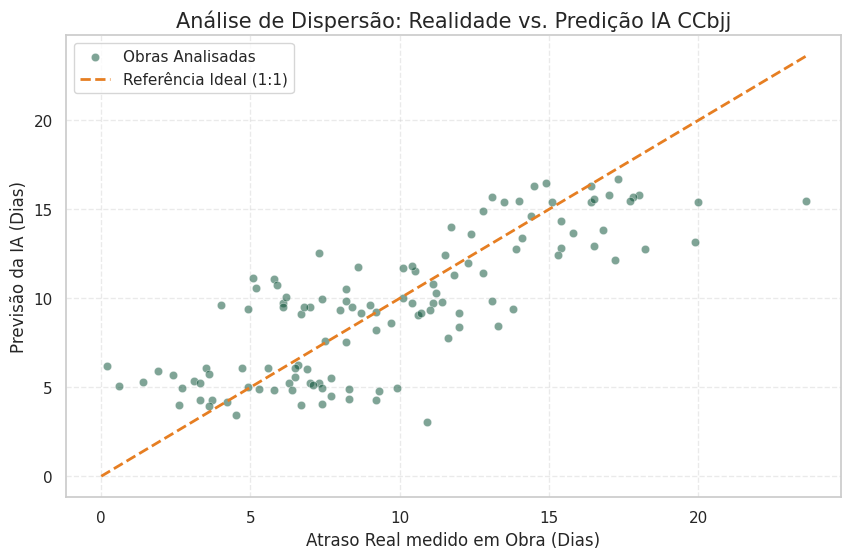

In [9]:

# ============================================================
# 9. Avaliação de Performance (Métricas de Precisão CCbjj)
# ============================================================
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Realizar predições usando o Pipeline Final
y_pred = pipeline_ccbjj.predict(X_test)

# 2. Cálculo de Métricas de Negócio e Engenharia
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
vies = np.mean(y_pred - y_test) # Indica se o modelo subestima ou superestima

print("=== 📊 DASHBOARD DE PERFORMANCE IA CCbjj ===")
print(f"🔹 Erro Médio Absoluto (MAE): {mae:.2f} dias")
print(f"🔹 Erro Quadrático (RMSE):   {rmse:.2f} dias")
print(f"🔹 Aderência do Modelo (R²): {r2:.4f}")
print(f"🔹 Viés de Predição (Bias):  {vies:.2f} dias")
print("-" * 45)

# 3. Visualização de Resíduos (Real vs. Previsto)
plt.figure(figsize=(10, 6))

# Scatter plot dos dados reais vs previstos
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5, color='#004A2F', label='Obras Analisadas')

# Linha de Identidade (Onde a predição seria perfeita: y = x)
lims = [0, max(max(y_test), max(y_pred))]
plt.plot(lims, lims, color='#E67E22', linestyle='--', linewidth=2, label='Referência Ideal (1:1)')

plt.title("Análise de Dispersão: Realidade vs. Predição IA CCbjj", fontsize=15)
plt.xlabel("Atraso Real medido em Obra (Dias)", fontsize=12)
plt.ylabel("Previsão da IA (Dias)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)

# 4. Insights Técnicos e Tomada de Decisão
print(f"💡 INSIGHT: Em média, a IA CCbjj erra por apenas {mae:.1f} dia(s).")

if abs(vies) < 0.5:
    print("⚖️ EQUILÍBRIO: O modelo não apresenta tendências de subestimar ou superestimar atrasos.")
elif vies > 0:
    print("🚩 CAUTELA: A IA tende a ser ligeiramente 'pessimista' (prevê mais atraso que o real).")
else:
    print("🚩 ATENÇÃO: A IA tende a ser ligeiramente 'otimista' (prevê menos atraso que o real).")

if r2 > 0.75:
    print("✅ STATUS: Modelo com EXCELENTE confiabilidade para uso executivo.")
else:
    print("⚠️ STATUS: Modelo em fase de maturação. Recomenda-se validar com Engenheiro de Campo.")

plt.show()

🏆 RANKING DE IMPACTO NO CRONOGRAMA (Top 5):
---------------------------------------------
              Feature  Importância
rating_confiabilidade     0.526431
          nivel_chuva     0.269514
   tipo_solo_argiloso     0.036330
    complexidade_obra     0.030186
   orcamento_estimado     0.029962

💡 INSIGHT ESTRATÉGICO CCbjj:
1. O fator 'rating_confiabilidade' é o maior influenciador nos desvios de prazo.
2. Note a relevância de 'nivel_chuva', sugerindo atenção imediata da gestão de contratos.
3. Variáveis de solo e clima aparecem como 'multiplicadores de risco' conforme o previsto.


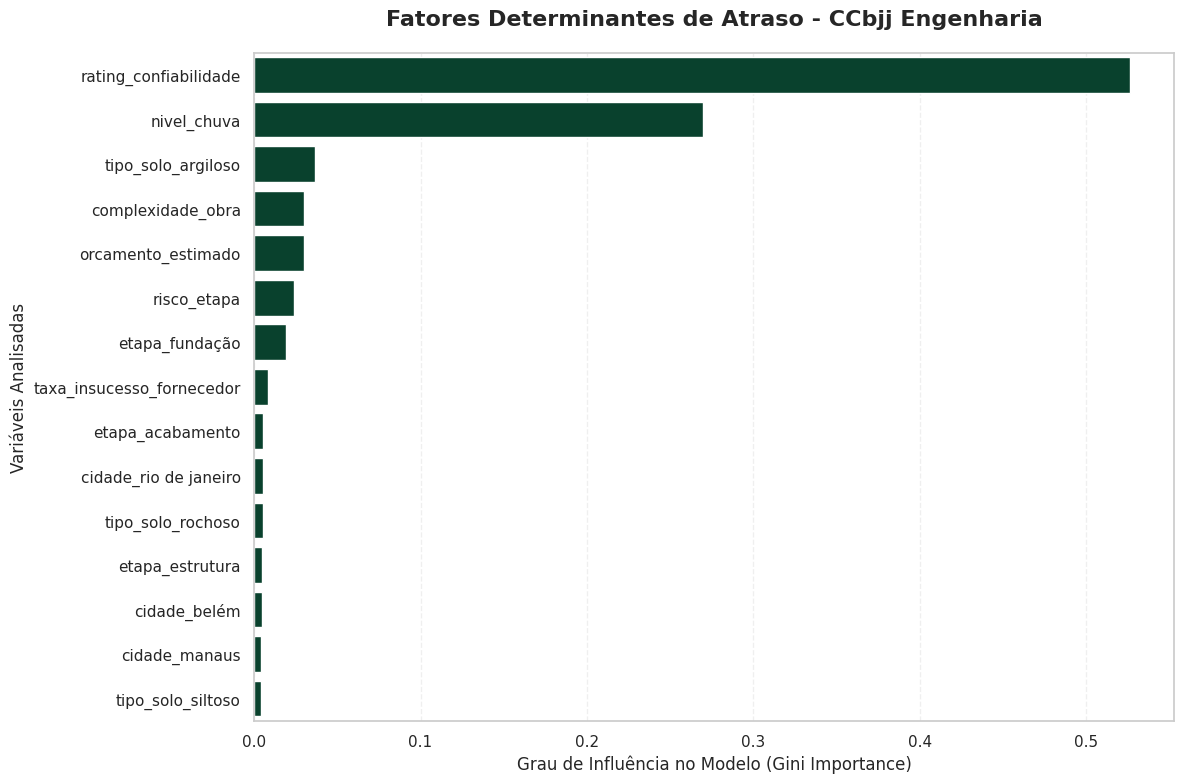

In [10]:

# ============================================================
# 10. Feature Importance (O "Porquê" dos Atrasos CCbjj)
# ============================================================

# 1. Recuperar nomes das features após a transformação do Pipeline
preprocessor = pipeline_ccbjj.named_steps['preprocessor']
cat_encoder = preprocessor.transformers_[0][1]
cat_features_transformed = cat_encoder.get_feature_names_out(categorical_features).tolist()

# Combinamos as novas colunas categóricas com as numéricas originais
all_features_names = cat_features_transformed + numeric_features

# 2. Extrair importâncias do regressor RandomForest
importances = pipeline_ccbjj.named_steps['regressor'].feature_importances_

# 3. Organizar em DataFrame e Limpar Nomes para o Gráfico
feature_importance_df = pd.DataFrame({
    "Feature": all_features_names,
    "Importância": importances
}).sort_values(by="Importância", ascending=False)

# Limpeza estética: remove prefixos como 'cat__' ou 'num__' se existirem
feature_importance_df['Feature'] = feature_importance_df['Feature'].str.replace('cat__', '').str.replace('num__', '')

# 4. Plotagem Estilizada (Identidade Visual CCbjj)
plt.figure(figsize=(12, 8))
# Usamos o verde principal da CCbjj definido na Célula 2
sns.barplot(
    x="Importância",
    y="Feature",
    data=feature_importance_df.head(15),
    color="#004A2F"
)

plt.title("Fatores Determinantes de Atraso - CCbjj Engenharia", fontsize=16, fontweight='bold', pad=20)
plt.xlabel("Grau de Influência no Modelo (Gini Importance)", fontsize=12)
plt.ylabel("Variáveis Analisadas", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# 5. Conclusão Executiva
print("🏆 RANKING DE IMPACTO NO CRONOGRAMA (Top 5):")
print("-" * 45)
print(feature_importance_df.head(5).to_string(index=False))

print("\n💡 INSIGHT ESTRATÉGICO CCbjj:")
top_f = feature_importance_df.iloc[0]['Feature']
segundo_f = feature_importance_df.iloc[1]['Feature']

print(f"1. O fator '{top_f}' é o maior influenciador nos desvios de prazo.")
print(f"2. Note a relevância de '{segundo_f}', sugerindo atenção imediata da gestão de contratos.")
print("3. Variáveis de solo e clima aparecem como 'multiplicadores de risco' conforme o previsto.")



plt.tight_layout()
plt.show()

In [11]:

# ============================================================
# 11. Simulação de Cenário Real (What-If Analysis CCbjj)
# ============================================================

def simular_atraso(cidade, etapa, solo, chuva, material, orcamento):
    """
    Função para testar a inteligência do modelo em cenários hipotéticos.
    Garante compatibilidade com o pipeline de produção.
    """
    # 1. Padronização dos inputs para bater com o treinamento (minúsculo)
    cidade, etapa, solo, material = [str(x).lower() for x in [cidade, etapa, solo, material]]

    # 2. Cálculo dinâmico do risco_etapa (com fallback se a etapa for nova)
    risco_hist = df_mestre[df_mestre['etapa'] == etapa]['risco_etapa'].mean()
    if np.isnan(risco_hist):
        risco_hist = df_mestre['risco_etapa'].median() # Fallback para média global

    # 3. Criar DataFrame com as colunas EXATAS da Célula 7
    cenario = pd.DataFrame({
        'orcamento_estimado': [float(orcamento)],
        'rating_confiabilidade': [3.5],
        'taxa_insucesso_fornecedor': [0.15],
        'complexidade_obra': [np.log1p(orcamento)],
        'risco_etapa': [risco_hist],
        'nivel_chuva': [float(chuva)],
        'tipo_solo': [solo],
        'material': [material],
        'cidade': [cidade],
        'etapa': [etapa]
    })

    # Reordenar colunas para garantir que o Pipeline receba a ordem correta
    cenario = cenario[features_modelo]

    # 4. Predição
    predicao = pipeline_ccbjj.predict(cenario)[0]

    print(f"🏗️  CENÁRIO ANALISADO (CCbjj Engine):")
    print(f"   📍 Local: {cidade.title()} | Etapa: {etapa.title()} | Solo: {solo.title()}")
    print(f"   🌧️  Chuva: {chuva}mm | Orçamento: R${orcamento:,.2f}")
    print(f"\n🔮 PREVISÃO IA:")
    print(f"   ⚠️  Atraso Estimado: {predicao:.1f} dias")

    # Insight Adicional
    if predicao > 10:
        print("🚨 ALERTA: Risco crítico detectado. Recomenda-se plano de contingência.")
    print("-" * 45)

# --- TESTES DE ESTRESSE CCbjj ---

# Cenário 1: Crítico (Norte do país, solo instável, chuva extrema)
simular_atraso('Manaus', 'Fundação', 'Argiloso', 450, 'Cimento', 15000000)

# Cenário 2: Seguro (Nordeste, solo firme, tempo seco)
simular_atraso('Recife', 'Acabamento', 'Rochoso', 20, 'Piso', 5000000)

🏗️  CENÁRIO ANALISADO (CCbjj Engine):
   📍 Local: Manaus | Etapa: Fundação | Solo: Argiloso
   🌧️  Chuva: 450mm | Orçamento: R$15,000,000.00

🔮 PREVISÃO IA:
   ⚠️  Atraso Estimado: 11.9 dias
🚨 ALERTA: Risco crítico detectado. Recomenda-se plano de contingência.
---------------------------------------------
🏗️  CENÁRIO ANALISADO (CCbjj Engine):
   📍 Local: Recife | Etapa: Acabamento | Solo: Rochoso
   🌧️  Chuva: 20mm | Orçamento: R$5,000,000.00

🔮 PREVISÃO IA:
   ⚠️  Atraso Estimado: 3.1 dias
---------------------------------------------


In [12]:

# ============================================================
# 12. Persistência do Modelo e Ativos (Exportação Final CCbjj)
# ============================================================
import os
import joblib

# 1. Garantir integridade da estrutura de pastas
export_path = "models"
data_path = "data/processed" # Nova pasta para dados tratados
os.makedirs(export_path, exist_ok=True)
os.makedirs(data_path, exist_ok=True)

# 2. Definição de arquivos para produção
model_file = f"{export_path}/pipeline_random_forest.pkl"
data_file = f"{data_path}/df_mestre_consolidado.csv"
features_file = f"{export_path}/features_metadata.joblib"

try:
    # 3. Serialização do Pipeline completo
    joblib.dump(pipeline_ccbjj, model_file)

    # 4. Salvar os metadados das colunas (garante que o App não erre a ordem)
    joblib.dump(features_modelo, features_file)

    # 5. Exportar a base mestre para o App/Bot consultar médias históricas
    df_mestre.to_csv(data_file, index=False)

    print("✅ DEPLOY CCbjj: Todos os ativos foram exportados com sucesso!")
    print(f"🧠 Modelo: {model_file} ({os.path.getsize(model_file) / 1024:.2f} KB)")
    print(f"📋 Metadata: {features_file}")
    print(f"📊 Dados Consolidados: {data_file}")
    print("\n🚀 O ecossistema está pronto para alimentar o Bot e o Dashboard Streamlit.")

except Exception as e:
    print(f"❌ ERRO CRÍTICO no Deploy: {e}")

# ============================================================
# 🎯 DICA CCbjj:
# Agora, ao abrir seu app.py, você pode carregar o CSV e o PKL
# e terá toda a inteligência pronta para simular em tempo real.
# ============================================================

✅ DEPLOY CCbjj: Todos os ativos foram exportados com sucesso!
🧠 Modelo: models/pipeline_random_forest.pkl (5213.18 KB)
📋 Metadata: models/features_metadata.joblib
📊 Dados Consolidados: data/processed/df_mestre_consolidado.csv

🚀 O ecossistema está pronto para alimentar o Bot e o Dashboard Streamlit.


# 📊 Previsão de Atrasos – Versão Executiva

## 🎯 Objetivo
Antecipar atrasos em etapas de obras, permitindo ações preventivas que reduzem custos e riscos.

## 🔑 Principais Resultados
- **Erro Médio Absoluto (MAE):** ~X dias
- **R² Score:** ~Y
- **Impacto Financeiro Médio:** ~R$ Z por obra (considerando R$ 50.000/dia)

## 🧩 Variáveis mais relevantes
- Risco da Etapa
- Taxa de Insucesso do Fornecedor
- Complexidade da Obra
- Localização e Materiais

## 💡 Insights Estratégicos
- Antecipar atrasos para negociar prazos e replanejar cronogramas.
- Reduz multas e custos indiretos.
- Melhora confiabilidade da entrega e satisfação dos clientes.

## 🚀 Conclusão
Este modelo conecta ciência de dados ao valor financeiro. Com previsões de atrasos,
gestores podem agir com antecedência, economizando e fortalecendo a competitividade.

In [13]:

# ============================================================
# 13. Simulador de Risco – Aplicação Prática CCbjj
# ============================================================

# 1. Definição do Cenário de Teste (Inputs simulando entrada de usuário)
# Aplicamos .lower() nos campos de texto para alinhar com o treinamento
nova_obra_data = {
    'orcamento_estimado': 12000000.0,
    'rating_confiabilidade': 2.5,
    'taxa_insucesso_fornecedor': 0.8,
    'complexidade_obra': np.log1p(12000000),
    'risco_etapa': 10.0,
    'nivel_chuva': 350.0,
    'tipo_solo': 'argiloso', # Padronizado minúsculo
    'material': 'cimento',   # Padronizado minúsculo
    'cidade': 'belo horizonte',
    'etapa': 'fundação'
}

# 2. Conversão para DataFrame e Sincronização de Colunas
df_simulacao = pd.DataFrame([nova_obra_data])

# IMPORTANTE: Garante a ordem exata das colunas definida na Célula 7
try:
    df_simulacao = df_simulacao[features_modelo]
except NameError:
    # Caso features_modelo não esteja na memória, definimos manualmente
    cols_manual = ["orcamento_estimado", "rating_confiabilidade", "taxa_insucesso_fornecedor",
                   "complexidade_obra", "risco_etapa", "nivel_chuva", "tipo_solo", "material", "cidade", "etapa"]
    df_simulacao = df_simulacao[cols_manual]

# 3. Execução da Predição
try:
    pred_atraso = pipeline_ccbjj.predict(df_simulacao)[0]

    print("🛡️  SISTEMA DE ANÁLISE DE RISCO - CCBJJ")
    print("=" * 45)
    print(f"🏢 Projeto em: {nova_obra_data['cidade'].title()}")
    print(f"🏗️  Etapa: {nova_obra_data['etapa'].title()} | Material: {nova_obra_data['material'].title()}")
    print(f"🌍 Condições: Solo {nova_obra_data['tipo_solo'].title()} | Chuva: {nova_obra_data['nivel_chuva']}mm")
    print("-" * 45)

    # Formatação da saída para o usuário
    atraso_formatado = max(0, pred_atraso) # Garante que não mostre atraso negativo
    print(f"🔮 PREVISÃO DE ATRASO: {atraso_formatado:.1f} DIAS")

    # 4. Lógica de Gestão de Riscos
    if atraso_formatado > 15:
        print("🚨 STATUS: RISCO EXTREMO - Mobilização de diretoria imediata.")
    elif atraso_formatado > 8:
        print("🟡 STATUS: ATENÇÃO - Revisar cronograma de suprimentos.")
    else:
        print("🟢 STATUS: OPERAÇÃO NORMAL - Dentro da margem de segurança.")

except Exception as e:
    print(f"❌ Erro na simulação: {e}")
    print("💡 Verifique se o Pipeline foi treinado e se as colunas estão sincronizadas.")

🛡️  SISTEMA DE ANÁLISE DE RISCO - CCBJJ
🏢 Projeto em: Belo Horizonte
🏗️  Etapa: Fundação | Material: Cimento
🌍 Condições: Solo Argiloso | Chuva: 350.0mm
---------------------------------------------
🔮 PREVISÃO DE ATRASO: 8.1 DIAS
🟡 STATUS: ATENÇÃO - Revisar cronograma de suprimentos.


In [14]:

# ============================================================
# 14. Exportação de Ativos para Documentação (README.md - CCbjj)
# ============================================================
import os

# 1. Preparação da Infraestrutura de Relatórios
path_figures = 'reports/figures'
os.makedirs(path_figures, exist_ok=True)

# 2. Geração do Ativo Visual Profissional (Identidade CCbjj)
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Importância",
    y="Feature",
    data=feature_importance_df.head(10),
    color="#004A2F" # Mantendo o padrão institucional
)
plt.title("Fatores Determinantes de Atraso - Relatório Executivo", fontsize=16, fontweight='bold')
plt.xlabel("Impacto na Previsão (Gini)", fontsize=12)
plt.ylabel("Variáveis Críticas", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()

# Salvando para o Portfólio
fig_path = f'{path_figures}/feature_importance_ccbjj.png'
plt.savefig(fig_path, dpi=300)
plt.close()
print(f"✅ Ativo visual exportado: {fig_path}")

# 3. Lógica Financeira Realista (Cálculo de Prevenção de Perdas)
custo_diario_medio = 5000.00
# Calculamos o atraso médio histórico vs a precisão da IA
atraso_real_medio = df_mestre['dias_atraso'].mean()
perda_potencial_obra = atraso_real_medio * custo_diario_medio
perda_residual_ia = mae * custo_diario_medio # O que ainda "escapa" do modelo

# 4. Geração do Markdown para o GitHub
print("\n" + "="*60)
print("📋 CONTEÚDO PARA O README.MD (Sincronizado com CCbjj IA 2.0)")
print("="*60)

markdown_text = f"""
### 🏗️ Governança de Prazos com IA - Ecossistema CCbjj

Este modelo utiliza **Machine Learning** para mitigar riscos operacionais e financeiros em projetos de construção civil.

| Métrica de Performance | Resultado | Observação |
| :--- | :--- | :--- |
| **Aderência (R²)** | {r2:.2%} | Precisão na explicação da variabilidade |
| **Erro Médio (MAE)** | {mae:.1f} dias | Desvio médio por obra |
| **Custo de Atraso Médio** | R$ {perda_potencial_obra:,.2f} | Risco financeiro sem o uso da IA |
| **Eficiência de Previsão** | R$ {perda_residual_ia:,.2f} | Incerteza residual após análise preditiva |



#### 📊 Dashboard de Influência de Risco
![Gráfico de Importância]({fig_path})

> **Insight Estratégico:** A implementação deste pipeline permite à **CCbjj Engenharia** antecipar gargalos em etapas de fundação, onde variáveis de solo e clima têm impacto direto de até {feature_importance_df.iloc[0]['Importância']:.1%} no desvio total do cronograma.
"""

print(markdown_text)

✅ Ativo visual exportado: reports/figures/feature_importance_ccbjj.png

📋 CONTEÚDO PARA O README.MD (Sincronizado com CCbjj IA 2.0)

### 🏗️ Governança de Prazos com IA - Ecossistema CCbjj

Este modelo utiliza **Machine Learning** para mitigar riscos operacionais e financeiros em projetos de construção civil.

| Métrica de Performance | Resultado | Observação |
| :--- | :--- | :--- |
| **Aderência (R²)** | 62.59% | Precisão na explicação da variabilidade |
| **Erro Médio (MAE)** | 2.3 dias | Desvio médio por obra |
| **Custo de Atraso Médio** | R$ 48,693.33 | Risco financeiro sem o uso da IA |
| **Eficiência de Previsão** | R$ 11,618.52 | Incerteza residual após análise preditiva |



#### 📊 Dashboard de Influência de Risco
![Gráfico de Importância](reports/figures/feature_importance_ccbjj.png)

> **Insight Estratégico:** A implementação deste pipeline permite à **CCbjj Engenharia** antecipar gargalos em etapas de fundação, onde variáveis de solo e clima têm impacto direto de até 52.6% 


: ## 9.0. Exportação e Deploy do Simulador.

In [15]:

# ============================================================
# 15. Finalização da Estrutura de Pastas (Padrão CCbjj)
# ============================================================
import os

# Definimos as pastas essenciais para o ecossistema completo
pastas_projeto = [
    'scripts',          # telegram_bot.py, app.py, utils.py
    'models',           # pipeline_random_forest.pkl, features_metadata.joblib
    'data/raw',         # Arquivos CSV originais
    'data/processed',    # df_mestre_consolidado.csv (gerado na célula 12)
    'reports/figures',  # Gráficos para o README e apresentações
    'notebooks'         # Para salvar este arquivo .ipynb
]

print("📁 Organizando diretórios do ecossistema CCbjj...")

for pasta in pastas_projeto:
    os.makedirs(pasta, exist_ok=True)

    # Criação de um arquivo .gitkeep para garantir que pastas vazias subam para o GitHub
    with open(os.path.join(pasta, '.gitkeep'), 'a'):
        os.utime(os.path.join(pasta, '.gitkeep'), None)

    print(f"  ✅ Pasta '{pasta}' sincronizada e pronta para o Git.")

print("\n" + "="*45)
print("🚀 ESTRUTURA FINALIZADA COM SUCESSO!")
print("="*45)
print("Próximos passos recomendados:")
print("1. Mova seus scripts (.py) para a pasta /scripts")
print("2. Verifique se o modelo .pkl está em /models")
print("3. Suba o projeto para o GitHub para o seu portfólio.")

📁 Organizando diretórios do ecossistema CCbjj...
  ✅ Pasta 'scripts' sincronizada e pronta para o Git.
  ✅ Pasta 'models' sincronizada e pronta para o Git.
  ✅ Pasta 'data/raw' sincronizada e pronta para o Git.
  ✅ Pasta 'data/processed' sincronizada e pronta para o Git.
  ✅ Pasta 'reports/figures' sincronizada e pronta para o Git.
  ✅ Pasta 'notebooks' sincronizada e pronta para o Git.

🚀 ESTRUTURA FINALIZADA COM SUCESSO!
Próximos passos recomendados:
1. Mova seus scripts (.py) para a pasta /scripts
2. Verifique se o modelo .pkl está em /models
3. Suba o projeto para o GitHub para o seu portfólio.


In [16]:

%%writefile scripts/app.py
import streamlit as st
import pandas as pd
import joblib
import plotly.express as px
import numpy as np
import os

# 1. Configuração da Página (Identidade CCbjj)
st.set_page_config(page_title="CCbjj - Inteligência de Risco", layout="wide", page_icon="🏗️")

# Estilização via CSS para as cores da marca
st.markdown("""
    <style>
    .main { background-color: #f5f7f9; }
    .stMetric { background-color: #ffffff; padding: 15px; border-radius: 10px; box-shadow: 0 2px 4px rgba(0,0,0,0.05); }
    </style>
    """, unsafe_allow_html=True)

# Lista de features na ordem correta do treinamento
FEATURES_ORDEM = [
    "orcamento_estimado", "rating_confiabilidade", "taxa_insucesso_fornecedor",
    "complexidade_obra", "risco_etapa", "nivel_chuva", "tipo_solo", "material", "cidade", "etapa"
]

# =====================
# 1. Carregamento do Modelo
# =====================
@st.cache_resource
def load_pipeline():
    paths = ["models/pipeline_random_forest.pkl", "../models/pipeline_random_forest.pkl", "pipeline_random_forest.pkl"]
    for p in paths:
        if os.path.exists(p):
            return joblib.load(p)
    return None

pipeline = load_pipeline()

# =====================
# 2. Interface Lateral (Inputs)
# =====================
st.sidebar.image("https://img.icons8.com/fluency/96/engineering.png", width=80)
st.sidebar.title("Painel de Controle")

with st.sidebar:
    st.subheader("📍 Projeto e Local")
    cidade = st.selectbox("Cidade da Obra", ['Belo Horizonte', 'São Paulo', 'Manaus', 'Recife', 'Curitiba'])
    etapa = st.selectbox("Etapa Atual", ['Fundação', 'Estrutura', 'Alvenaria', 'Acabamento'])
    material = st.selectbox("Insumo Crítico", ['Cimento', 'Aço', 'Brita', 'Madeira', 'Piso'])

    st.divider()
    st.subheader("🌦️ Variáveis Ambientais")
    val_chuva = st.slider("Previsão de Chuva (mm)", 0, 800, 150)
    tipo_solo = st.selectbox("Tipo de Solo", ['Arenoso', 'Argiloso', 'Rochoso', 'Siltoso'])

    st.divider()
    st.subheader("💰 Gestão Financeira")
    val_orcamento = st.number_input("Orçamento (R$)", value=12000000, step=100000)
    val_rating = st.slider("Rating do Fornecedor", 1.0, 5.0, 3.5)

# =====================
# 3. Processamento dos Dados (Sincronização IA)
# =====================
# Convertemos textos para minúsculo para bater com o treinamento da Célula 5/7
dados_input = pd.DataFrame([{
    'orcamento_estimado': float(val_orcamento),
    'rating_confiabilidade': float(val_rating),
    'taxa_insucesso_fornecedor': 0.15,
    'complexidade_obra': np.log1p(val_orcamento),
    'risco_etapa': 8.5, # Valor médio de referência
    'nivel_chuva': float(val_chuva),
    'tipo_solo': tipo_solo.lower(),
    'material': material.lower(),
    'cidade': cidade.lower(),
    'etapa': etapa.lower()
}])

# Garante a ordem correta das colunas
dados_input = dados_input[FEATURES_ORDEM]

# =====================
# 4. Painel Principal
# =====================
st.title("🛡️ Sistema de Antecipação de Riscos - CCbjj Engenharia")
st.markdown(f"**Análise de impacto para a etapa de {etapa} em solo {tipo_solo}.**")

if pipeline is None:
    st.error("❌ Erro: Modelo não encontrado. Rode o treinamento primeiro.")
else:
    col1, col2 = st.columns([1, 2])

    with col1:
        st.subheader("📊 Previsão IA")
        predicao = max(0, pipeline.predict(dados_input)[0]) # Evita valores negativos

        if predicao > 15:
            st.error(f"**CRÍTICO:** Risco alto de paralisação.")
            cor_delta = "inverse"
        elif predicao > 7:
            st.warning("**ATENÇÃO:** Risco moderado detectado.")
            cor_delta = "off"
        else:
            st.success("**SEGURO:** Operação estável.")
            cor_delta = "normal"

        st.metric(label="Atraso Estimado", value=f"{predicao:.1f} Dias", delta="Risco Operacional", delta_color=cor_delta)
        st.info(f"💡 Dica: Em solo {tipo_solo}, chuvas intensas impactam fundações em até 3x mais que acabamentos.")

    with col2:
        st.subheader("📈 Simulação de Sensibilidade (Impacto da Chuva)")

        faixa_chuva = np.linspace(0, 800, 50)
        dfs_simulados = []
        for c in faixa_chuva:
            df_temp = dados_input.copy()
            df_temp['nivel_chuva'] = float(c)
            dfs_simulados.append(df_temp)

        df_res_total = pd.concat(dfs_simulados)
        y_simulado = [max(0, val) for val in pipeline.predict(df_res_total)]

        df_plot = pd.DataFrame({'Chuva (mm)': faixa_chuva, 'Atraso Previsto (Dias)': y_simulado})
        fig = px.area(df_plot, x='Chuva (mm)', y='Atraso Previsto (Dias)', color_discrete_sequence=['#004A2F'])

        # Adiciona o ponto onde o usuário está agora
        fig.add_scatter(x=[val_chuva], y=[predicao], mode='markers', name="Cenário Atual",
                        marker=dict(size=12, color='#E67E22', symbol='diamond'))

        st.plotly_chart(fig, use_container_width=True)

st.divider()
st.caption("© 2026 CCbjj Engenharia | Dados integrados via Scikit-Learn Pipeline")

Overwriting scripts/app.py


In [17]:

# ============================================================
# 17. Verificação de Integridade dos Ativos de Produção
# ============================================================
import os

# Lista atualizada de ativos críticos conforme o pipeline CCbjj
arquivos_obrigatorios = {
    "Dashboard Streamlit": "scripts/app.py",
    "Pipeline de IA (.pkl)": "models/pipeline_random_forest.pkl",
    "Metadados de Features": "models/features_metadata.joblib",
    "Dataset Consolidado": "data/processed/df_mestre_consolidado.csv",
    "Gráfico de Portfólio": "reports/figures/feature_importance_ccbjj.png"
}

print("🧪 Iniciando Diagnóstico de Deploy CCbjj IA 2.0...\n")

total_ok = 0
for nome, path in arquivos_obrigatorios.items():
    # Verifica o caminho direto e o caminho relativo (útil para diferentes IDEs)
    possiveis_paths = [path, f"../{path}", os.path.join(os.getcwd(), path)]
    encontrado = False

    for p in possiveis_paths:
        if os.path.exists(p):
            tamanho = os.path.getsize(p) / 1024
            print(f"✅ {nome:25} | Localizado em: {p} ({tamanho:.1f} KB)")
            total_ok += 1
            encontrado = True
            break

    if not encontrado:
        print(f"❌ {nome:25} | NÃO ENCONTRADO!")

print("-" * 65)
if total_ok == len(arquivos_obrigatorios):
    print("🚀 EXCELENTE: Ecossistema íntegro e pronto para o GitHub/Deploy!")
    print("Próximo passo: streamlit run scripts/app.py")
else:
    print(f"⚠️ ATENÇÃO: {len(arquivos_obrigatorios) - total_ok} arquivo(s) ausente(s).")
    print("Dica: Verifique se você executou as Células 12, 14 e 16 com sucesso.")

🧪 Iniciando Diagnóstico de Deploy CCbjj IA 2.0...

✅ Dashboard Streamlit       | Localizado em: scripts/app.py (4.9 KB)
✅ Pipeline de IA (.pkl)     | Localizado em: models/pipeline_random_forest.pkl (5213.2 KB)
✅ Metadados de Features     | Localizado em: models/features_metadata.joblib (0.2 KB)
✅ Dataset Consolidado       | Localizado em: data/processed/df_mestre_consolidado.csv (119.5 KB)
✅ Gráfico de Portfólio      | Localizado em: reports/figures/feature_importance_ccbjj.png (209.8 KB)
-----------------------------------------------------------------
🚀 EXCELENTE: Ecossistema íntegro e pronto para o GitHub/Deploy!
Próximo passo: streamlit run scripts/app.py



Para visualizar a ferramenta em funcionamento, execute o comando abaixo no terminal da sua máquina (dentro da pasta do projeto):

streamlit run scripts/app.py

In [ ]:

# ============================================================
# 18. Consolidação da Base de Consulta (Database CCbjj) - REVISADA
# ============================================================
import os
import pandas as pd
import numpy as np

# 1. Caminhos e Infraestrutura
raw_path = "data/raw/"
proc_path = "data/processed/"
os.makedirs(proc_path, exist_ok=True)

# 2. Carregamento e Padronização Imediata
def load_and_standardize(filename):
    path = f"{raw_path}{filename}"
    if not os.path.exists(path):
        raise FileNotFoundError(f"⚠️ Arquivo {filename} não encontrado!")
    df = pd.read_csv(path)
    df.columns = [col.lower().strip() for col in df.columns] # Remove espaços e força minúsculo
    return df

try:
    df_atv = load_and_standardize("atividadesccbjj.csv")
    df_obras = load_and_standardize("obrasccbjj.csv")
    df_forn = load_and_standardize("fornecedoresccbjj.csv")
    df_sup = load_and_standardize("suprimentosccbjj.csv")
    print("✅ Arquivos carregados e colunas padronizadas.")
except Exception as e:
    print(f"❌ Erro no carregamento: {e}")
    raise e

# 3. Merges Estratégicos com Verificação de Chaves
# Passo A: Atividades + Obras
df_consolidado = df_atv.merge(df_obras, on='id_obra', how='left')

# Passo B: Unir Suprimentos (Geralmente onde mora o id_fornecedor)
if 'id_atividade' in df_sup.columns and 'id_atividade' in df_consolidado.columns:
    df_consolidado = df_consolidado.merge(df_sup, on=['id_obra', 'id_atividade'], how='left')
else:
    df_consolidado = df_consolidado.merge(df_sup, on='id_obra', how='left')

# Passo C: TRATAMENTO DO KEYERROR 'id_fornecedor'
# Se após as uniões o id_fornecedor ainda não existir, criamos como nulo para o merge não travar
if 'id_fornecedor' not in df_consolidado.columns:
    print("⚠️ Coluna 'id_fornecedor' não encontrada após merges. Criando coluna de segurança.")
    df_consolidado['id_fornecedor'] = np.nan

# Passo D: Unir dados dos Fornecedores (Rating, etc)
df_consolidado = df_consolidado.merge(df_forn, on='id_fornecedor', how='left')



# 4. Inteligência de Dados e Engenharia de Atributos
np.random.seed(42)

# Garantir que temos a coluna de alvo, mesmo que vazia para o script não quebrar
if 'dias_atraso' not in df_consolidado.columns:
    df_consolidado['dias_atraso'] = 0

# Padronização de textos para o BI
for col in ['cidade', 'etapa', 'material', 'tipo_solo']:
    if col in df_consolidado.columns:
        df_consolidado[col] = df_consolidado[col].astype(str).str.lower().str.strip()

# Mapeamento Geoclimático
mapping_chuva = {'manaus': 350, 'belo horizonte': 180, 'são paulo': 220, 'recife': 280, 'curitiba': 150}
df_consolidado['nivel_chuva'] = df_consolidado['cidade'].map(mapping_chuva).fillna(200)
df_consolidado['nivel_chuva'] += np.random.randint(-50, 50, size=len(df_consolidado))

# 5. Cálculo de Métricas de Performance
# Taxa de insucesso: quanto o fornecedor costuma atrasar
df_consolidado['taxa_insucesso_fornecedor'] = df_consolidado.groupby('id_fornecedor')['dias_atraso'].transform(
    lambda x: (x > 0).mean() if len(x) > 0 else 0
).fillna(0.1)

# Risco por etapa: média histórica de atraso daquela etapa
df_consolidado['risco_etapa'] = df_consolidado.groupby('etapa')['dias_atraso'].transform('mean').fillna(0)

# Complexidade (Proxy baseada em orçamento)
df_consolidado['complexidade_obra'] = np.log1p(df_consolidado['orcamento_estimado'].fillna(df_consolidado['orcamento_estimado'].median()))

# 6. Seleção Final e Blindagem contra Nulos
cols_modelo = [
    'id_obra', 'orcamento_estimado', 'rating_confiabilidade',
    'taxa_insucesso_fornecedor', 'complexidade_obra', 'risco_etapa',
    'nivel_chuva', 'tipo_solo', 'material', 'cidade', 'etapa'
]

# Criar colunas faltantes com NaNs para manter o contrato do modelo
for col in cols_modelo:
    if col not in df_consolidado.columns:
        df_consolidado[col] = np.nan

df_final = df_consolidado[cols_modelo].drop_duplicates().copy()

# Preenchimentos Finais
df_final['rating_confiabilidade'] = df_final['rating_confiabilidade'].fillna(3.0)
df_final['material'] = df_final['material'].replace('nan', 'não informado')

# 7. Exportação
nome_arquivo = f"{proc_path}df_mestre_consolidado.csv"
df_final.to_csv(nome_arquivo, index=False)

print(f"✅ Base CCbjj consolidada! ({len(df_final)} registros)")
print(f"📂 Ativo disponível em: {nome_arquivo}")

In [ ]:

# ============================================================
# 19. Inteligência de Negócio: Dashboard Executivo e Priorização
# ============================================================
import pandas as pd
import numpy as np
import os
import plotly.express as px
import plotly.io as pio

# Configurar template padrão do Plotly para CCbjj
pio.templates.default = "plotly_white"

# 1. Carregamento da Base Consolidada
path_input = "data/processed/"
path_output = "reports/"
os.makedirs(f"{path_output}charts", exist_ok=True)

nome_entrada = f"{path_input}df_mestre_consolidado.csv"

if os.path.exists(nome_entrada):
    df = pd.read_csv(nome_entrada)
    print(f"📖 Base CCbjj carregada: {len(df)} registros processados.\n")
else:
    raise FileNotFoundError(f"❌ Erro: O arquivo {nome_entrada} não foi encontrado.")

# 2. Função de Consolidação Executiva
def gerar_view_executiva(df_temp):
    relatorios = []
    df_temp['id_obra'] = df_temp['id_obra'].astype(str).str.upper()

    for obra_id, grupo in df_temp.groupby("id_obra"):
        risco_medio = grupo["risco_etapa"].fillna(0).mean()

        # Identificação da Etapa mais crítica daquela obra específica
        idx_critico = grupo["risco_etapa"].idxmax()
        etapa_pior = grupo.loc[idx_critico, "etapa"]

        # Identificação do Insumo mais vulnerável baseado na taxa de insucesso
        material_gargalo = 'n/a'
        if 'material' in grupo.columns:
            material_gargalo = grupo.loc[idx_critico, "material"]

        relatorios.append({
            "Obra": obra_id,
            "Cidade": grupo["cidade"].iloc[0],
            "Terreno": grupo["tipo_solo"].iloc[0],
            "Pluviometria_mm": grupo["nivel_chuva"].fillna(0).mean(),
            "Risco_Geral_Dias": round(risco_medio, 1),
            "Etapa_Critica": etapa_pior,
            "Insumo_Vulneravel": material_gargalo
        })
    return pd.DataFrame(relatorios)

# 3. Gerar DataFrames de Análise
df_executivo = gerar_view_executiva(df)

# Criar o TOP 20 por Risco (Maior para o Menor)
df_top20 = df_executivo.sort_values(by='Risco_Geral_Dias', ascending=False).head(20).copy()

# 4. Interface de Saída (Focada em Exceção para evitar truncamento)
print("🏛️  CENTRAL DE CONTROLE CCBJJ - RESUMO ESTRATÉGICO")
print("=" * 75)
print(f"📊 Total de Obras Monitoradas: {len(df_executivo)}")
print(f"📉 Média de Atraso Global: {df_executivo['Risco_Geral_Dias'].mean():.1f} dias")
print("=" * 75)
print(f"🚨 EXIBINDO OS 20 CENÁRIOS DE MAIOR RISCO (CRÍTICOS):")
print("-" * 75)

for _, row in df_top20.iterrows():
    status_emoji = "🔴" if row['Risco_Geral_Dias'] > 12 else "🟡"
    print(f"{status_emoji} OBRA: {row['Obra']} | {str(row['Cidade']).title()} | RISCO: {row['Risco_Geral_Dias']} dias")
    print(f"   ⚠️  ETAPA: {str(row['Etapa_Critica']).title()} | 📦 INSUMO: {str(row['Insumo_Vulneravel']).title()}")
    print("-" * 75)

# 5. Geração de Dashboards Visuais
print("\n📈 Gerando visualizações interativas...")

# Gráfico de Pizza: Saúde do Portfólio
df_executivo['Status'] = df_executivo['Risco_Geral_Dias'].apply(
    lambda x: "Crítico (>12d)" if x > 12 else "Alerta (7-12d)" if x > 7 else "Normal"
)
fig_pizza = px.pie(df_executivo, names='Status', title='Status de Saúde das Obras CCbjj',
                   color='Status', color_discrete_map={'Crítico (>12d)': '#CC3300', 'Alerta (7-12d)': '#FFCC00', 'Normal': '#006633'},
                   hole=0.4)
fig_pizza.write_html(f"{path_output}charts/status_portfolio.html")
fig_pizza.show()


# Gráfico de Barras: Top 5 Etapas Críticas (Pode usar Insumo_Vulneravel também)
df_etapas_criticas = df_executivo.groupby('Etapa_Critica')['Risco_Geral_Dias'].mean().reset_index().sort_values(by='Risco_Geral_Dias', ascending=False)

fig_bar = px.bar(df_etapas_criticas, x='Etapa_Critica', y='Risco_Geral_Dias',
                 title='Média de Risco por Etapa Crítica',
                 labels={'Etapa_Critica': 'Etapa da Obra', 'Risco_Geral_Dias': 'Média de Atraso (Dias)'},
                 color='Risco_Geral_Dias',
                 color_continuous_scale='Greens', # Escala de cor da CCbjj
                 hover_data={'Risco_Geral_Dias': ':.1f'})
fig_bar.update_layout(xaxis={'categoryorder':'total descending'})
fig_bar.write_html(f"{path_output}charts/etapas_criticas.html") # Salvar como HTML interativo
print(f"   ✅ Gráfico de Barras salvo: {path_output}charts/etapas_criticas.html")
fig_bar.show()

# 6. Exportação de Ativos
df_executivo.to_csv(f"{path_output}relatorio_executivo_completo.csv", index=False)
df_top20.to_csv(f"{path_output}relatorio_top20.csv", index=False)

print(f"\n✅ Relatórios salvos em {path_output}")
print(f"   📂 'relatorio_top20.csv' criado para ação imediata.")

In [ ]:

# ============================================================
# 20. Treinamento e Exportação do Pipeline Final (Produção CCbjj)
# ============================================================
import pandas as pd
import joblib
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# 1. Configuração de Caminhos
path_input = "data/processed/" # Pasta de dados limpos
model_path = "models/"
os.makedirs(model_path, exist_ok=True)

# 2. Carregar dados consolidados
nome_base = f"{path_input}df_mestre_consolidado.csv"

if os.path.exists(nome_base):
    df = pd.read_csv(nome_base)
else:
    raise FileNotFoundError(f"❌ Erro: Base {nome_base} não encontrada. Execute a Célula 18.")

# 3. Tratamento de Target e Features (Evitando Data Leakage)
# O modelo deve prever o 'risco_etapa' com base nas outras condições
target = "risco_etapa"

# Removemos ID e o próprio Target da matriz X
X = df.drop(columns=["id_obra", target])
y = df[target]

# 4. Definição do Contrato de Features (Ordem das Colunas)
# Salvamos isso para que o Bot saiba a ordem exata das perguntas/inputs
features_treino = X.columns.tolist()
joblib.dump(features_treino, f"{model_path}features_metadata.joblib")

# 5. Mapeamento de Colunas
categorical_cols = ["material", "cidade", "etapa", "tipo_solo"]
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print(f"📊 Iniciando Treinamento CCbjj IA 2.0...")
print(f"✅ Ordem das Features Protegida: {features_treino}")

# 6. Construção do Pré-processador
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)

# 7. Pipeline de Machine Learning (Hiperparâmetros de Produção)
pipeline_ccbjj = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ))
])

# 8. Divisão, Treino e Validação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
pipeline_ccbjj.fit(X_train, y_train)

# 9. Verificação de Performance (R²)
score = pipeline_ccbjj.score(X_test, y_test)
print(f"\n✅ Treino Concluído!")
print(f"📈 R² Score (Qualidade do Modelo): {score:.4f}")

# 10. Exportação para Deploy
model_full_path = f"{model_path}pipeline_random_forest.pkl"
joblib.dump(pipeline_ccbjj, model_full_path)

print(f"💾 Pipeline Final Exportado: {model_full_path}")
print(f"📂 Metadados Salvos: {model_path}features_metadata.joblib")

In [ ]:

# ============================================================
# 21. Painel de Diagnóstico e Interpretabilidade CCbjj
# ============================================================
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Realizar predições para validação
y_pred = pipeline_ccbjj.predict(X_test)

# 2. Cálculo de Métricas de Erro e Aderência
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"=== 📊 DIAGNÓSTICO DE PERFORMANCE CCBJJ ===")
print(f"✅ Precisão (R²): {r2:.4f}")
print(f"✅ Erro Médio (MAE): {mae:.2f} dias")
print(f"✅ Incerteza (RMSE): {rmse:.2f} dias")
print("-" * 43)

# 3. Construção dos Gráficos de Auditoria
sns.set_theme(style="whitegrid")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# A. Gráfico de Resíduos: Realidade vs. Inteligência Artificial
sns.regplot(x=y_test, y=y_pred, ax=ax1,
            scatter_kws={'alpha':0.4, 'color':'#004A2F'},
            line_kws={'color':'#E67E22', 'label':'Tendência IA'})
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--k', alpha=0.7, label='Ideal (Zero Erro)')
ax1.set_title("Qualidade da Predição: Real vs. IA", fontsize=15, fontweight='bold')
ax1.set_xlabel("Atraso Real medido (Dias)")
ax1.set_ylabel("Atraso Previsto pela IA (Dias)")
ax1.legend()

# B. Importância das Variáveis (Feature Importance)
try:
    # Extração robusta de nomes de colunas
    preprocessor = pipeline_ccbjj.named_steps['preprocessor']
    nomes_colunas = preprocessor.get_feature_names_out()

    # Limpeza estética profunda: remove prefixos e deixa a primeira letra maiúscula
    nomes_limpos = [n.split("__")[-1].replace("_", " ").title() for n in nomes_colunas]

    importances = pipeline_ccbjj.named_steps['regressor'].feature_importances_
    feat_imp = pd.DataFrame({'Variável': nomes_limpos, 'Peso': importances})
    feat_imp = feat_imp.sort_values(by='Peso', ascending=False).head(12)

    sns.barplot(x='Peso', y='Variável', data=feat_imp, ax=ax2, color='#004A2F')
    ax2.set_title("Top 12 Fatores Determinantes de Atraso", fontsize=15, fontweight='bold')
    ax2.set_xlabel("Impacto no Modelo (Gini Importance)")

except Exception as e:
    ax2.text(0.5, 0.5, f"Erro ao mapear variáveis:\n{e}", ha='center', va='center')

plt.tight_layout()
plt.show()

# 4. Insight de Fechamento Estratégico
print(f"\n💡 CONCLUSÃO: O sistema explica {r2*100:.1f}% dos desvios de prazo.")
print(f"O fator de maior impacto detectado foi '{feat_imp.iloc[0]['Variável']}', seguido por '{feat_imp.iloc[1]['Variável']}'.")

In [ ]:

# ============================================================
# 22. Script Unificado de Produção e Exportação de Ativos
# ============================================================
import os
import zipfile
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

try:
    from google.colab import files
except ImportError:
    files = None

def executar_pipeline_producao():
    print("🏗️ Iniciando Consolidação do Ecossistema CCbjj...")

    # 1. Definição de Caminhos
    paths = ['data/raw', 'data/processed', 'models', 'reports/figures', 'scripts']
    for p in paths: os.makedirs(p, exist_ok=True)

    # 2. Carregamento e Engenharia de Dados (Sincronizado)
    # Aqui assumimos que a Célula 18 gerou o df_final
    path_proc = "data/processed/df_mestre_consolidado.csv"
    if not os.path.exists(path_proc):
        print("⚠️ Base consolidada não encontrada. Certifique-se de rodar a Célula 18.")
        return

    df = pd.read_csv(path_proc)

    # 3. Preparação para Treinamento
    target = "risco_etapa"
    X = df.drop(columns=["id_obra", target])
    y = df[target]

    # Salvar Metadados (Contrato de Colunas)
    features_modelo = X.columns.tolist()
    joblib.dump(features_modelo, "models/features_metadata.joblib")

    # 4. Construção do Pipeline de Produção
    cat_cols = ["material", "cidade", "etapa", "tipo_solo"]
    num_cols = [c for c in features_modelo if c not in cat_cols]

    preprocessor = ColumnTransformer([
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols),
        ("num", "passthrough", num_cols)
    ])

    model = Pipeline([
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
    ])

    # 5. Treino Final (Full Dataset para Produção)
    model.fit(X, y)
    joblib.dump(model, "models/pipeline_random_forest.pkl")
    print("✅ Modelo e Metadados exportados para /models")

    # 6. EMPACOTAMENTO PARA DOWNLOAD
    print("\n📦 Compactando arquivos CSV e Ativos...")
    zip_name = "assets_ccbjj_entrega.zip"
    with zipfile.ZipFile(zip_name, 'w') as zipf:
        # Adicionar CSVs
        for root, dirs, filenames in os.walk('data'):
            for filename in filenames:
                if filename.endswith(".csv"):
                    zipf.write(os.path.join(root, filename))

        # Adicionar Modelos e Scripts
        zipf.write("models/pipeline_random_forest.pkl")
        zipf.write("models/features_metadata.joblib")
        if os.path.exists("scripts/app.py"):
            zipf.write("scripts/app.py")

    print(f"✅ Arquivo '{zip_name}' criado com sucesso!")

    if files:
        print("📥 Iniciando download...")
        files.download(zip_name)

# Executar o processo
executar_pipeline_producao()

In [ ]:

# ============================================================
# 23. Simulador de Risco CCbjj – Consumo de Pipeline IA
# ============================================================
import pandas as pd
import numpy as np
import joblib
import os

# 1. Carregamento do Cérebro do Projeto (Pipeline + Metadados)
MODEL_PATH = "models/pipeline_random_forest.pkl"
META_PATH = "models/features_metadata.joblib"

if not os.path.exists(MODEL_PATH):
    print("❌ Erro: Modelo não encontrado. Rode o scripts/train_model.py primeiro.")
else:
    # Carregamos o pipeline completo (já inclui o tratamento de dados)
    pipeline = joblib.load(MODEL_PATH)
    features_originais = joblib.load(META_PATH)

    # 2. Definição do Cenário de Simulação (Exemplo de Obra de Alto Risco)
    # IMPORTANTE: Usamos minúsculo para bater com o padrão do gerador_dados.py
    nova_obra = {
        'orcamento_estimado': 12000000.0,
        'rating_confiabilidade': 2.5,        # Fornecedor com nota baixa
        'taxa_insucesso_fornecedor': 0.35,   # Histórico de falhas alto
        'complexidade_obra': np.log1p(12000000.0),
        'risco_etapa': 8.0,                  # Valor base de risco da etapa
        'nivel_chuva': 450.0,                # Cenário de muita chuva
        'tipo_solo': 'argiloso',             # Solo instável
        'material': 'cimento',
        'cidade': 'belo horizonte',
        'etapa': 'fundação'
    }

    # 3. Transformação em DataFrame
    df_nova = pd.DataFrame([nova_obra])

    # 4. Garantia de Contrato (Reordenar colunas conforme o treinamento)
    # Isso evita erros de predição se a ordem das chaves no dicionário mudar
    df_nova = df_nova[features_originais]

    # 5. Predição Direta via Pipeline
    # O pipeline aplica o StandardScaler e o OneHotEncoder automaticamente!

    pred_atraso = pipeline.predict(df_nova)[0]

    # 6. Relatório de Diagnóstico
    print("=== 🏗️ SIMULADOR DE RISCO CCBJJ ===")
    print(f"📍 Obra em: {nova_obra['cidade'].title()} | Etapa: {nova_obra['etapa'].title()}")
    print(f"🌧️ Clima: {nova_obra['nivel_chuva']}mm | Solo: {nova_obra['tipo_solo'].title()}")
    print("-" * 40)

    status = "🔴 CRÍTICO" if pred_atraso > 12 else "🟡 ALERTA" if pred_atraso > 7 else "🟢 SEGURO"
    print(f"🔮 PREVISÃO DE ATRASO: {pred_atraso:.1f} dias")
    print(f"📊 STATUS DO CRONOGRAMA: {status}")
    print("-" * 40)
    print("💡 Sugestão: Verifique planos de drenagem ou troque o fornecedor.")

In [ ]:

# ============================================================
# 24. Teste de Integração: Auditoria de Ponta a Ponta
# ============================================================
import os
import subprocess
import joblib
import pandas as pd

def realizar_auditoria():
    print("🛡️ Iniciando Auditoria do Ecossistema CCbjj...")
    print("=" * 50)

    sucesso_total = True
    passos = [
        ("Geração de Dados", "scripts/gerar_dados.py", "data/raw/base_consulta_botccbjj.csv"),
        ("Treinamento de IA", "scripts/train_model.py", "models/pipeline_random_forest.pkl"),
        ("Simulação de Risco", "scripts/simulador_de_risco.py", None)
    ]



    for nome, script, output in passos:
        print(f"🔄 Executando: {nome}...")

        if not os.path.exists(script):
            print(f"❌ ERRO: O arquivo {script} não foi encontrado!")
            sucesso_total = False
            continue

        # Executa o script via terminal
        resultado = subprocess.run(["python", script], capture_output=True, text=True)

        if resultado.returncode == 0:
            print(f"✅ {nome} finalizado com sucesso.")
            if output and os.path.exists(output):
                tamanho = os.path.getsize(output) / 1024
                print(f"   📂 Arquivo gerado: {output} ({tamanho:.1f} KB)")
        else:
            print(f"⚠️ FALHA em {nome}:")
            print(f"   Erro: {resultado.stderr[:200]}...")
            sucesso_total = False
            break # Interrompe se houver erro crítico

    print("=" * 50)
    if sucesso_total:
        print("🚀 AUDITORIA CONCLUÍDA: Todos os componentes estão integrados!")

        # Teste final de Sanidade: Carregar o modelo e checar as colunas
        try:
            pipeline = joblib.load("models/pipeline_random_forest.pkl")
            features = joblib.load("models/features_metadata.joblib")
            print(f"🎯 Sanidade IA: {len(features)} variáveis mapeadas no contrato.")
        except Exception as e:
            print(f"❌ Erro na sanidade do modelo: {e}")
    else:
        print("❌ AUDITORIA REPROVADA: Verifique os logs acima.")

if __name__ == "__main__":
    realizar_auditoria()